In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Unsupervised NLP

### Semantics
- Supervised learning: knows often used words, parts of speech, but not the meanings of words
    - Couldn't say whether 'lady' is more similar to 'queen' or 'car'
    - Synonyms become problematic
    - Connotative information is lost
- Not having semantic information limits NLP applicability
- Feeding this explicitly to supervised models is basically impossible
- Unsupervised learning: NNs in particular 
    - Can learn these rules through pattern identification
    - Use trained unsupervised model to understand new sentences
    - Limited by corpus (just like supervised learners); a model trained on novels will be poor at medical text
    - Latent Semantic Analysis

### Converting sentences to vectors
- Term-document matrix: column for each sentence (document) and row for each word
    - 'Document' is a flexible term to mean individual chunks of text
    - Can be sentences, paragraphs, entire files, etc
- Weighting: words that occur in many different sentences weighted lower than those that occur in fewer sentences

### Quantifying documents
- **Document frequency (*df*):** how many documents a word appears in
- **Collection frequency (*cf*):** how often a word appears total over all documents

### Penalizing indiscriminate words
- **Inverse document frequency (*idf*):**
    - Calculate ratio of total docs (*N*) divided by *df*, take log (base 2) to get *idf* for each term (*t*)
    - $ idf_t = log\dfrac N{df_t}$
    
### Term-frequency weights
- Weights for how frequently a term appears within a document
    - $tf - idf_{t,d} = (tf_{t,d})(idf_t)$
    - More frequent gets higher weights for that document
    - tf_idf score highest for a term occuring a lot within a small number of documents
    - tf_idf score lowest for a term occuring in most or all sentences
- 'Translation' from human-readable language to computer-usable numeric form
- Some information loss is inevitable
- Decision-points during translation step
    - Which stop words to include or exclude
    - Whether to use phrases as terms ('Monty Python' instead of 'Monty' and 'Python')
    - Threshold for infrequent words (longer documents may warrant higher thresholds)
    - How many terms to keep (longer documents may end up creating very long vectors)

## Vector Space Model
- **VSM:** the vector representation of the text
- Used to compute the similarity between known documents and new ones
    - Search engines use to match query to possible results
- Sentences exist in *n*-dimensional space where *n* is equal to the number of terms in term-doc matrix
- Computing similarity:
    - Transform new document into a vector and place in this space
    - Calculate how different the angles are for original vector and new vector
    - Identify vector whose angle is closest to the new vector angle
        - Typically cosine of the angle between the vectors
        - Identical vectors: angle = 0 and cosine = 1
        - Orthogonal vectors: angle = 90 and cosine = 0
        - Higher cosine = higher similarity
        
## Latent Semantic Analysis

- **Limitations to VSM:**
    - Treats each word as distinct from all others
        - Synonyms can be treated as different from one another (big & large)
    - Treats all occurrences of a term as the same, regardless of context
        - Polysemy: the same word has different meanings attached (taking a break vs. breaking something)
    - Difficulty with very large documents
        - The more words in a document the more opportunities to diverge from other documents in the space
        - Can make finding similarities difficult
- **Latent Semantic Analysis (LSA):** also known as Latent Semantic Indexing
    - Apply PCA to a tf-idf term-doc matrix
    - Reduces full matrix to a lower dimensional space
    - Combines information from multiple terms into a single new one, resulting in fewer rows
    - Outputs clusters of terms that (presumably) reflect a topic
    - Each doc is scored for each topic, higher scores = higher relevance to the topic
    - Docs can pertain to more than one topic
- LSA is useful for:
    - Very large corpus
    - Unsure about which topics characterize documents
    - Creating features to use in other models

In [8]:
#example: comparing paragrahs within Emma by Jane Austen
import nltk
nltk.download('punkt')
from nltk.corpus import gutenberg
nltk.download('gutenberg')
import re
from sklearn.model_selection import train_test_split

#read data in paragraph form
emma = gutenberg.paras('austen-emma.txt')

emma_paras = []
for paragraph in emma:
    para = paragraph[0]
    #remove double-dash
    para = [re.sub(r'--','',word) for word in para]
    #format each paragraph into a string, add to list of strings
    emma_paras.append(' '.join(para))

print(emma_paras[0:4])

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/brianmcguckin/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package gutenberg to
[nltk_data]     /Users/brianmcguckin/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
['[ Emma by Jane Austen 1816 ]', 'VOLUME I', 'CHAPTER I', 'Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very little to distress or vex her .']


In [11]:
#using sklearn tfidf
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test = train_test_split(emma_paras, test_size=0.4, random_state=0)
vectorizer = TfidfVectorizer(max_df=0.5, #drop words occuring in more than half of the paragrahs
                             min_df=2, #words must appear at least twice
                             stop_words='english',
                             lowercase=True, #lower case since alice capitalizes words for emphasis
                             use_idf=True, #use idf for weighting
                             norm=u'l2', #correction factor, longer & shorter paras treated equally
                             smooth_idf=True) #adds one to all doc freqs, avoids div by 0 errors
#apply vectorizer
emma_paras_tfidf = vectorizer.fit_transform(emma_paras)
print('no. of feats: %d' % emma_paras_tfidf.get_shape()[1])

#train & test sets
X_train_tfidf, X_test_tfidf = train_test_split(emma_paras_tfidf,
                                               test_size=0.4,
                                               random_state=0)
#reshape output for readability
X_train_tfidf_csr = X_train_tfidf.tocsr()

#no. of paragraphs
n = X_train_tfidf_csr.shape[0]

#list of dictionaries (one per para)
tfidf_bypara = [{} for _ in range(0,n)]

#list of features
terms = vectorizer.get_feature_names()

#list feature words & tf-idf scores for each para
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i,j]
    
#since log base 2 of 1 = 0, tf-idf of 0 means word was present once
print('original sentence:', X_train[5])
print('tf_idf vector:', tfidf_bypara[5])

no. of feats: 1948
original sentence: A very few minutes more , however , completed the present trial .
tf_idf vector: {'minutes': 0.7127450310382584, 'present': 0.701423210857947}


In [17]:
#dimension reduction: using SVD over PCA because PCA mean-centers variables (loses sparsity)
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#SVD data reducer
svd = TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))

#run svd on training data then project training data
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained = svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print('percent variance captured: {}'.format(total_variance*100))

#see what paragraphs are considered similar for first 5 topics
paras_by_component = pd.DataFrame(X_train_lsa, index=X_train)
for i in range(5):
    print('component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

percent variance captured: 45.18983055539586
component 0:
" Oh !     0.999284
" Oh !"    0.999284
" Oh !     0.999284
" Oh !     0.999284
" Oh !"    0.999284
" Oh !     0.999284
" Oh !     0.999284
" Oh !     0.999284
" Oh !     0.999284
" Oh !     0.999284
Name: 0, dtype: float64
component 1:
" You have made her too tall , Emma ," said Mr . Knightley .                                                                                                                0.634699
" You get upon delicate subjects , Emma ," said Mrs . Weston smiling ; " remember that I am here . Mr .                                                                     0.576832
" I do not know what your opinion may be , Mrs . Weston ," said Mr . Knightley , " of this great intimacy between Emma and Harriet Smith , but I think it a bad thing ."    0.561547
" You are right , Mrs . Weston ," said Mr . Knightley warmly , " Miss Fairfax is as capable as any of us of forming a just opinion of Mrs . Elton .               

## Sentence Similarity

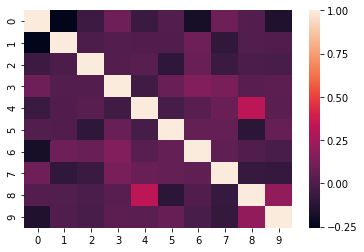

key:
0 That is _court_ .
1 " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
2 " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
3 To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on being

In [18]:
#compute document similarity using lsa components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)

#first 10 sentences
sim_matrix = pd.DataFrame(similarity, index=X_train).iloc[0:10,0:10]

#make plot
ax = sns.heatmap(sim_matrix, yticklabels=range(10))
plt.show()

#generate key for plot
print('key:')
for i in range(10):
    print(i, sim_matrix.index[i])

## Drill 0: Test set
Apply LSA model to test set

In [30]:
#reshape output for readability
X_test_tfidf_csr = X_test_tfidf.tocsr()

#number of paragraphs
n = X_test_tfidf_csr.shape[0]

#dictionaries
tfidf_bypara = [{} for _ in range(0,n)]

#list of features
terms = vectorizer.get_feature_names()

#feature words and tf-idf scores
for i, j in zip(*X_test_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_test_tfidf_csr[i,j]
    
print('original sentence:', X_test[5])
print('tf_idf vector:', tfidf_bypara[5])

original sentence: " And I am quite serious too , I assure you ," replied Mrs . Elton gaily , " in resolving to be always on the watch , and employing my friends to watch also , that nothing really unexceptionable may pass us ."
tf_idf vector: {'resolving': 0.2774191165193505, 'also': 0.23044247889104402, 'unexceptionable': 0.2589497988171934, 'assure': 0.21689513115302067, 'serious': 0.22172306773030476, 'friends': 0.20377398658436527, 'quite': 0.1552585713313441, 'replied': 0.16458059338939593, 'nothing': 0.16621195958420604, 'watch': 0.504715627998901, 'elton': 0.1367071745545188, 'may': 0.1679204262351428, 'pass': 0.23044247889104402, 'on': 0.12180212724011232, 'am': 0.1452704048380038, 'my': 0.12398388239402786, 'always': 0.17717390643975056, 'us': 0.19183382863312068, 'you': 0.09665948426551466, 'really': 0.17793510964706347, 'mrs': 0.11974456723163628, 'be': 0.097232748184252, 'that': 0.09665948426551466, 'too': 0.17033170735790376, 'in': 0.0946064191634381}


In [31]:
X_test_lsa = lsa.transform(X_test_tfidf)

print('percent variance captured: {}'.format(
    (svd.explained_variance_ratio_.sum()*100)))

percent variance captured: 49.72676536945169


In [32]:
paras_by_component = pd.DataFrame(X_test_lsa, index=X_test)
for i in range(5):
    print('component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

component 0:
" Oh !     0.780338
" Oh !     0.780338
" Oh !     0.780338
" Oh !     0.780338
" Oh !     0.780338
" Oh !     0.780338
" Oh !     0.780338
" Oh !     0.780338
" Oh !"    0.780338
" Oh !     0.780338
Name: 0, dtype: float64
component 1:
" Oh !    0.624636
" Oh !    0.624636
" Oh !    0.624636
" Oh !    0.624636
" Oh !    0.624636
" Oh !    0.624636
" Oh !    0.624636
" Oh !    0.624636
" Oh !    0.624636
" Oh !    0.624636
Name: 1, dtype: float64
component 2:
" I thank you ; but I assure you you are quite mistaken .                                                                                         0.593853
" You are ungrateful ."                                                                                                                           0.529507
" You are sick of prosperity and indulgence .                                                                                                     0.524702
" Emma , my love , you said that this circumstance would n

## Drill 1: tweaking tf-idf

Change up decision points from original translation, see how LSA is affected

In [28]:
#change max_df to a stricter threshold and leave stop words in
vectorizer = TfidfVectorizer(max_df=0.25, #drop words occuring in more than 25% of the paragrahs
                             min_df=2, #words must appear at least twice
                             #stop_words='english',
                             lowercase=True, #lower case since alice capitalizes words for emphasis
                             use_idf=True, #use idf for weighting
                             norm=u'l2', #correction factor, longer & shorter paras treated equally
                             smooth_idf=True) #adds one to all doc freqs, avoids div by 0 errors
#apply
emma_paras_tfidf = vectorizer.fit_transform(emma_paras)
print('train set')
print('no. feats: %d' % emma_paras_tfidf.get_shape()[1])

#train/test
X_train_tfidf, X_test_tfidf = train_test_split(emma_paras_tfidf,
                                               test_size=0.4,
                                               random_state=0)

X_train_tfidf_csr = X_train_tfidf.tocsr()

#num paragraphs
n = X_train_tfidf_csr.shape[0]

#dicts
tfidf_bypara = [{} for _ in range(0,n)]

#feats
terms = vectorizer.get_feature_names()

#words & scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i,j]
    
#dimension reduction
svd = TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
X_train_lsa = lsa.fit_transform(X_train_tfidf)

print('% variance captured: {}'.format(
    svd.explained_variance_ratio_.sum()*100))

train set
no. feats: 2174
% variance captured: 49.72676536945169


In [33]:
#same as above plus increase min_df to 5
vectorizer = TfidfVectorizer(max_df=0.25, #drop words occuring in more than 25% of the paragrahs
                             min_df=5, #words must appear at least twice
                             #stop_words='english',
                             lowercase=True, #lower case since alice capitalizes words for emphasis
                             use_idf=True, #use idf for weighting
                             norm=u'l2', #correction factor, longer & shorter paras treated equally
                             smooth_idf=True) #adds one to all doc freqs, avoids div by 0 errors
#apply
emma_paras_tfidf = vectorizer.fit_transform(emma_paras)
print('train set')
print('no. feats: %d' % emma_paras_tfidf.get_shape()[1])

#train/test
X_train_tfidf, X_test_tfidf = train_test_split(emma_paras_tfidf,
                                               test_size=0.4,
                                               random_state=0)

X_train_tfidf_csr = X_train_tfidf.tocsr()

#num paragraphs
n = X_train_tfidf_csr.shape[0]

#dicts
tfidf_bypara = [{} for _ in range(0,n)]

#feats
terms = vectorizer.get_feature_names()

#words & scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i,j]
    
#dimension reduction
svd = TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
X_train_lsa = lsa.fit_transform(X_train_tfidf)

print('% variance captured: {}'.format(
    svd.explained_variance_ratio_.sum()*100))

train set
no. feats: 997
% variance captured: 57.92243127099559


In [34]:
#try same as above but put stop words back in
vectorizer = TfidfVectorizer(max_df=0.25, #drop words occuring in more than 25% of the paragrahs
                             min_df=5, #words must appear at least twice
                             stop_words='english',
                             lowercase=True, #lower case since alice capitalizes words for emphasis
                             use_idf=True, #use idf for weighting
                             norm=u'l2', #correction factor, longer & shorter paras treated equally
                             smooth_idf=True) #adds one to all doc freqs, avoids div by 0 errors
#apply
emma_paras_tfidf = vectorizer.fit_transform(emma_paras)
print('train set')
print('no. feats: %d' % emma_paras_tfidf.get_shape()[1])

#train/test
X_train_tfidf, X_test_tfidf = train_test_split(emma_paras_tfidf,
                                               test_size=0.4,
                                               random_state=0)

X_train_tfidf_csr = X_train_tfidf.tocsr()

#num paragraphs
n = X_train_tfidf_csr.shape[0]

#dicts
tfidf_bypara = [{} for _ in range(0,n)]

#feats
terms = vectorizer.get_feature_names()

#words & scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i,j]
    
#dimension reduction
svd = TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
X_train_lsa = lsa.fit_transform(X_train_tfidf)

print('% variance captured: {}'.format(
    svd.explained_variance_ratio_.sum()*100))

train set
no. feats: 799
% variance captured: 55.8604452556428
